In [ ]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 799.8 kB/s eta 0:00:00


In [ ]:
import os
import numpy as np
# import tensorflow as tf
# from tensorflow import keras
import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds
# from tensorflow.keras import layers
import time
# import utils.utils as utils
# Defining the global variables.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8
# Training for single epoch for time constraint.
# Please use atleast 30 epochs to see good results.
EPOCHS = 1
# AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision import models
from torchsummary import summary
from torchvision.models.feature_extraction import create_feature_extractor

def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image
def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def st_ada_in(style_features, content_cur_masked_features, content_prev_masked_features, alpha = 0.1):
    # print('#', style_features.shape, content_cur_masked_features.shape, content_prev_masked_features.shape) #BxCxSxS

    x_cur_mean, x_cur_std = calc_mean_std(content_cur_masked_features)
    x_prev_mean, x_prev_std = calc_mean_std(content_prev_masked_features)

    # print('#', type(alpha), type(x_cur_mean), type(x_prev_mean))
    combined_mean = (1-alpha) * x_cur_mean + alpha * x_prev_mean
    combined_std = (1-alpha) * x_cur_std + alpha * x_prev_std

    style_mean, style_std = calc_mean_std(style_features)

    result = style_std * (content_cur_masked_features - combined_mean) / combined_std + style_mean
    # print('#', x_cur_mean.shape, result.shape)
    return result

def get_VGG_feature_extractor():
    # vgg_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    # vgg_layer_names = ["ReLU-2", "ReLU-7", "ReLU-12", "ReLU-21"]
    vgg_fixed = torchvision.models.vgg19(weights='IMAGENET1K_V1')
    for param in vgg_fixed.parameters():
        param.requires_grad = False

    # train_nodes, eval_nodes = get_graph_node_names(vgg_fixed)
    # print(train_nodes, eval_nodes)

    # To specify the nodes you want to extract, you could select the final node
    # that appears in each of the main layers:
    return_nodes = {
        # node_name: user-specified key for output dict
        'features.2': 'layer1',
        'features.7': 'layer2',
        'features.12': 'layer3',
        'features.21': 'layer4',
    }

    return create_feature_extractor(vgg_fixed, return_nodes=return_nodes)


class SpatioTemporalTransferModel(nn.Module):
    def __init__(self, vgg_feature_extractor):
        super(SpatioTemporalTransferModel, self).__init__()
        self.vgg_feature_extractor = vgg_feature_extractor

        #define splatting blocks' layers
        self.sb_11 = ConvBlock(in_channels=64, out_channels=8, kernel_size=3,  padding="same", stride=2)
        self.sb_12 = ConvBlock(in_channels=8, out_channels=8, kernel_size=3,  padding="same", stride=1)
        self.sb_13 = ConvBlock(in_channels=8, out_channels=8, kernel_size=3,  padding="same", stride=1)
        self.sb_1_short = ConvBlock(in_channels=128, out_channels=8, kernel_size=3,  padding="same", stride=1)

        self.sb_21 = ConvBlock(in_channels=8, out_channels=16, kernel_size=3,  padding="same", stride=2)
        self.sb_22 = ConvBlock(in_channels=16, out_channels=16, kernel_size=3,  padding="same", stride=1)
        self.sb_23 = ConvBlock(in_channels=16, out_channels=16, kernel_size=3,  padding="same", stride=1)
        self.sb_2_short = ConvBlock(in_channels=256, out_channels=16, kernel_size=3,  padding="same", stride=1)

        self.sb_31 = ConvBlock(in_channels=16, out_channels=32, kernel_size=3,  padding="same", stride=2)
        self.sb_32 = ConvBlock(in_channels=32, out_channels=32, kernel_size=3,  padding="same", stride=1)
        self.sb_33 = ConvBlock(in_channels=32, out_channels=32, kernel_size=3,  padding="same", stride=1)
        self.sb_3_short = ConvBlock(in_channels=512, out_channels=32, kernel_size=3,  padding="same", stride=1)

        self.l_1 = ConvBlock(in_channels=32, out_channels=64, kernel_size=3,  padding="same", stride=2)
        self.l_2 = ConvBlock(in_channels=64, out_channels=64, kernel_size=3,  padding="same", stride=1)

        self.gp_1 = ConvBlock(in_channels=64, out_channels=64, kernel_size=3,  padding="same", stride=1)

        self.gp_2 = ConvBlock(in_channels=64, out_channels=96, kernel_size=1,  padding="same", stride=1) #TODO : activation none?
        return

    def forward(self, style, content, mask, content_prev_encoded, temp_content_prev_1, temp_content_prev_2, temp_content_prev_3, mask_prev):
        # Encode the style and content image.

        style_encoded_dict = self.vgg_feature_extractor(style)
        style_encoded = [style_encoded_dict[f'layer{i}'] for i in range(1,5)]

        content_encoded_dict = self.vgg_feature_extractor(content * mask)
        content_encoded = [content_encoded_dict[f'layer{i}'] for i in range(1,5)]

        # for c in content_encoded:
        #     print(c.shape)
            # print(c)
            # break

        # Compute the AdaIN target feature maps.
        st_ada_in_outputs = []
        # skip block1_conv1
        skipCount = 1
        count = 0

        # print('!!!!!!', len(style_encoded), len(content_encoded), len(content_prev_encoded))

        for encoded_features in zip(style_encoded, content_encoded, content_prev_encoded):
            # print('! ', count)
            if count < skipCount:
                count += 1
                continue
            # TODO : manage prev features and consider mask shape
            st_ada_in_output = st_ada_in(encoded_features[0], encoded_features[1], encoded_features[2], alpha = 0.1)
            st_ada_in_outputs.append(st_ada_in_output)

        temp_content = self.sb_11(content_encoded[0]) #input is c_in
        temp_style = self.sb_11(style_encoded[0]) #input is s_in
        #TODO corresponding prev variables and mask
        temp_content_stylized = st_ada_in(temp_style, temp_content, temp_content_prev_1, alpha = 0.1)
        temp_content_prev_1 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_1_short(st_ada_in_outputs[0])
        temp_content_stylized = self.sb_12(temp_content_stylized)
        temp_content_stylized = self.sb_13(temp_content_stylized) #c_out
        # print('here', temp_style.shape)
        temp_style = self.sb_13(temp_style) #s_out

        temp_content = self.sb_21(temp_content_stylized) #input is c_in
        temp_style = self.sb_21(temp_style) #input is s_in
        #TODO corresponding prev variables and mask
        temp_content_stylized = st_ada_in(temp_style, temp_content, temp_content_prev_2, alpha = 0.1)
        temp_content_prev_2 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_2_short(st_ada_in_outputs[1])
        temp_content_stylized = self.sb_22(temp_content_stylized)
        temp_content_stylized = self.sb_23(temp_content_stylized) #c_out
        temp_style = self.sb_23(temp_style) #s_out

        temp_content = self.sb_31(temp_content_stylized) #input is c_in
        temp_style = self.sb_31(temp_style) #input is s_in
        #TODO corresponding prev variables and mask
        temp_content_stylized = st_ada_in(temp_style, temp_content, temp_content_prev_3, alpha = 0.1)
        temp_content_prev_3 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_3_short(st_ada_in_outputs[2])
        temp_content_stylized = self.sb_32(temp_content_stylized)
        temp_content_stylized = self.sb_33(temp_content_stylized) #c_out
        temp_style = self.sb_33(temp_style) #s_out

        temp_content_stylized = self.l_1(temp_content_stylized)
        temp_content_stylized = self.l_2(temp_content_stylized) #stylized_features

        #grid prediction
        bilateral_grid = self.gp_1(temp_content_stylized)
        bilateral_grid = self.gp_2(bilateral_grid)

        content_prev_encoded = content_encoded.copy()

        return bilateral_grid, content_prev_encoded, temp_content_prev_1, temp_content_prev_2, temp_content_prev_3


class SoftGridMask(nn.Module):
    def __init__(self):
        super(SoftGridMask, self).__init__()

    def create_soft_grid_mask(self, z, M_px, w, h, W, H, D):
        #TODO check reduce_sum against algo
        M_grid = torch.tensor(np.zeros((D, W, H)), dtype=torch.float32)
        print((z * M_px * D).shape)
        z_D = torch.floor((z * M_px) * D)
        s_w, s_h = w//W, h//H

        for x in range(W):
            for y in range(H):
                patch = z_D[x * s_w : (x + 1) * s_w, y*s_h:(y+1)*s_h]
                M_grid[:,x,y] = torch.sum(torch.where(patch > 0, patch, torch.zeros_like(patch)))
                for d in range(D):
                    if torch.any(patch == d):
                        M_grid[d,x,y] = torch.sum(torch.where(patch == d, patch, torch.zeros_like(patch)))
        M_grid = M_grid / (s_w * s_h)
        return M_grid

    def forward(self, z, M_px, w, h, W, H, D):
        #TODO : use create mask function
        return self.create_soft_grid_mask(z, M_px, w, h, W, H, D)


class GridBlender(nn.Module):
    def __init__(self):
        super(GridBlender, self).__init__()

    def forward(self, grids, soft_grid_mask):
        #TODO : use grid blending function
        out = torch.zeros_like(grids[0])
        for g in grids:
            out = torch.add(out, g)
        return out
#########################################################################################################
class MaskedVideoStyleTransfer(nn.Module):
    # def __init__(self, spatio_temporal_model, grid_blender, guide, slice, apply_coeffs, soft_grid_mask):
    #     super(MaskedVideoStyleTransfer, self).__init__()
    #     self.spatio_temporal_model = spatio_temporal_model
    #     self.grid_blender = grid_blender
    #     self.guide = guide
    #     self.slice = slice
    #     self.apply_coeffs = apply_coeffs
    #     self.soft_grid_mask = soft_grid_mask
    def __init__(self):
        super(MaskedVideoStyleTransfer, self).__init__()
        self.vgg_feature_extractor = get_VGG_feature_extractor()
        self.spatio_temporal_model = SpatioTemporalTransferModel(self.vgg_feature_extractor)
        self.grid_blender = GridBlender()
        self.guide = GuideNN()
        self.slice = Slice()
        self.apply_coeffs = ApplyCoeffs()
        self.soft_grid_mask = SoftGridMask()



    def forward(self, content, mask_cur_list, style_list, content_prev, mask_prev_list, content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list):
        # content, mask_cur_list, style_list, content_prev, mask_prev_list = inputs
        print(content.shape, len(mask_cur_list), len(style_list), content_prev.shape, len(mask_prev_list), len(content_prev_encoded_list), len(temp_content_prev_1_list), len(temp_content_prev_2_list), len(temp_content_prev_3_list))

        # #prev values
        # content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list = None, None, None, None

        bilateral_grid_list = []
        for classId in range(len(mask_cur_list)):
            bilateral_grid, content_prev_encoded, temp_content_prev_1, temp_content_prev_2, temp_content_prev_3 = self.spatio_temporal_model(style_list[classId], content, mask_cur_list[classId], content_prev_encoded_list[classId], temp_content_prev_1_list[classId], temp_content_prev_2_list[classId], temp_content_prev_3_list[classId], mask_prev_list[classId])

            content_prev_encoded_list[classId], temp_content_prev_1_list[classId], temp_content_prev_2_list[classId], temp_content_prev_3_list[classId] = content_prev_encoded, temp_content_prev_1, temp_content_prev_2, temp_content_prev_3

            bilateral_grid_list.append(bilateral_grid)

        guide = self.guide(content)
        soft_grid_mask = self.soft_grid_mask(guide, mask_cur_list[0], 256, 256, 32, 32, 96)
        #TODO: handle multiple masks, one for each class
        blended_grid = self.grid_blender(bilateral_grid_list, soft_grid_mask)
        blended_grid_ = blended_grid.reshape(blended_grid.shape[0],12,-1,blended_grid.shape[-2],blended_grid.shape[-1])
        slice_coeffs = self.slice(blended_grid_, guide)
        output = self.apply_coeffs(slice_coeffs, content)

        #TODO : loss calculation, gradient calculation, backpropagation
        return output, blended_grid, guide, content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list
########################################################################################################

# class LaplacianRegularizer2D(nn.Module):
#     def __init__(self):
#         super(LaplacianRegularizer, self).__init__()
#         self.mse_loss = torch.nn.MSELoss(reduction='sum')
#     def forward(self,f):
#         loss = 0.
#         for i in range(f.shape[2]):
#             for j in range(f.shape[3]):
#                 up = max(i-1,0)
#                 down = min(i+1,f.shape[2] - 1)
#                 left = max(j-1,0)
#                 right = min(j+1,f.shape[3] - 1)
#                 term = f[:,:,i,j].view(f.shape[0],f.shape[1],1,1).expand(f.shape[0],f.shape[1],down - up+1,right-left+1)
#                 loss += self.mse_loss(term,f[:,:,up:down+1,left:right+1])
#         return loss

class LaplacianRegularizer3D(nn.Module):
    def __init__(self):
        super(LaplacianRegularizer3D, self).__init__()
        self.mse_loss = torch.nn.MSELoss(reduction='sum')

    def forward(self, f):
        loss = 0.
        # f: [B, 12, 8, H, W]
        f = f.reshape(f.shape[0],12,8,f.shape[2],f.shape[-1])
        B, C, D, H, W = f.shape
        for k in range(D):
            for i in range(H):
                for j in range(W):
                    front = max(k - 1, 0)
                    back = min(k + 1, D - 1)
                    up = max(i - 1, 0)
                    down = min(i + 1, H - 1)
                    left = max(j - 1, 0)
                    right = min(j + 1, W - 1)
                    term = f[:, :, k, i, j].view(B, C, 1, 1, 1).expand(B, C, back - front + 1, down - up + 1, right - left + 1)
                    loss += self.mse_loss(term, f[:, :, front:back + 1, up:down + 1, left:right + 1])
        return loss

# # true laplacian_regularizer of original paper, input weight is coeffs in 5-dimension form
# def calc_laplacian_regularizer_loss(self, weights, l1=0.0, l2=0.0):
#         if not l1 and not l2:
#             return 0.0
#         diff1 = weights[:, :, 1:, :, :] - weights[:, :, :-1, :, :]
#         diff2 = weights[:, :, :, 1:, :] - weights[:, :, :, :-1, :]
#         diff3 = weights[:, :, :, :, 1:] - weights[:, :, :, :, :-1]
#         if l1:
#             result1 = torch.abs(diff1).sum()
#             result1 += torch.abs(diff2).sum()
#             result1 += torch.abs(diff3).sum()
#         if l2:
#             result2 = torch.pow(diff1, 2).sum()
#             result2 += torch.pow(diff2, 2).sum()
#             result2 += torch.pow(diff3, 2).sum()
#         if l1 and not l2:
#             return result1
#         elif not l1 and l2:
#             return result2
#         else:
#             return result1 + result2

class Slice(nn.Module):
    def __init__(self):
        super(Slice, self).__init__()

    def forward(self, bilateral_grid, guidemap):
        device = bilateral_grid.get_device()

        N, _, H, W = guidemap.shape
        hg, wg = torch.meshgrid([torch.arange(0, H), torch.arange(0, W)]) # [0,511] HxW
        if device >= 0:
            hg = hg.to(device)
            wg = wg.to(device)
        hg = hg.float().repeat(N, 1, 1).unsqueeze(3) / (H-1) * 2 - 1 # norm to [-1,1] NxHxWx1
        wg = wg.float().repeat(N, 1, 1).unsqueeze(3) / (W-1) * 2 - 1 # norm to [-1,1] NxHxWx1
        guidemap = guidemap.permute(0,2,3,1).contiguous()
        guidemap_guide = torch.cat([wg, hg, guidemap], dim=3).unsqueeze(1) # Nx1xHxWx3
        coeff = F.grid_sample(bilateral_grid, guidemap_guide)
        return coeff.squeeze(2)

class ApplyCoeffs(nn.Module):
    def __init__(self):
        super(ApplyCoeffs, self).__init__()
        self.degree = 3

    def forward(self, coeff, full_res_input):

        '''
            Affine:
            r = a11*r + a12*g + a13*b + a14
            g = a21*r + a22*g + a23*b + a24
            ...
        '''

        R = torch.sum(full_res_input * coeff[:, 0:3, :, :], dim=1, keepdim=True) + coeff[:, 3:4, :, :]
        G = torch.sum(full_res_input * coeff[:, 4:7, :, :], dim=1, keepdim=True) + coeff[:, 7:8, :, :]
        B = torch.sum(full_res_input * coeff[:, 8:11, :, :], dim=1, keepdim=True) + coeff[:, 11:12, :, :]

        return torch.cat([R, G, B], dim=1)

class GuideNN(nn.Module):
    def __init__(self, params=None):
        super(GuideNN, self).__init__()
        self.params = params
        self.conv1 = ConvBlock(3, 16, kernel_size=1, padding=0, batch_norm=False)
        self.conv2 = ConvBlock(16, 1, kernel_size=1, padding=0, activation=nn.Tanh)

    def forward(self, x):
        return self.conv2(self.conv1(x))


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding="same", stride=1, use_bias=True, activation=nn.ReLU,
                 batch_norm=False):
        super(ConvBlock, self).__init__()
        reflection_padding = kernel_size // 2 # same dimension after padding
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), kernel_size, stride=stride, bias=use_bias)
        self.activation = activation() if activation else None
        self.bn = nn.BatchNorm2d(out_channels) if batch_norm else None

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        if self.activation:
            x = self.activation(x)
        return x

In [ ]:
stm = SpatioTemporalTransferModel(get_VGG_feature_extractor())
V = 256
D = 224
temp = np.ones((1,3,V,V))
# print(temp.shape)
a,b,c,d,e = stm.forward(torch.tensor(temp, dtype=torch.float32), torch.tensor(temp, dtype=torch.float32),
            torch.tensor(np.ones((1,1,V,V)), dtype=torch.float32), [torch.tensor(np.zeros((1, 64, 224, 224)), dtype=torch.float32), torch.tensor(np.zeros((1, 128, 112, 112)), dtype=torch.float32), torch.tensor(np.zeros((1, 256, 56, 56)), dtype=torch.float32), torch.tensor(np.zeros((1, 512, 28, 28)), dtype=torch.float32)],
            torch.tensor(np.zeros((1, 8, 112, 112)), dtype=torch.float32), torch.tensor(np.zeros((1, 16, 56, 56)), dtype=torch.float32),
            torch.tensor(np.zeros((1, 32, 28, 28)), dtype=torch.float32), torch.tensor(np.ones((1,1,V,V)), dtype=torch.float32))
print(a.shape)

torch.Size([1, 96, 16, 16])


In [ ]:
g = GuideNN()
z = g(torch.tensor(np.zeros((1, 3, 256, 256)), dtype=torch.float32))
print(z.shape)

torch.Size([1, 1, 256, 256])


In [ ]:
sgm = SoftGridMask()
sm = sgm.create_soft_grid_mask(z, torch.tensor(np.zeros((1, 1, 256, 256)), dtype=torch.float32), 256, 256, 16, 16, 96)
print(sm.shape)

torch.Size([1, 1, 256, 256])
torch.Size([96, 16, 16])


In [ ]:
slice = Slice()
slice_coeffs = slice(a.reshape(a.shape[0],12,-1,a.shape[-2],a.shape[-1]), z)
print(slice_coeffs.shape)

torch.Size([1, 12, 256, 256])


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [ ]:
apply = ApplyCoeffs()
apply_coeffs = apply(slice_coeffs, torch.tensor(temp, dtype=torch.float32))
print(apply_coeffs.shape)

torch.Size([1, 3, 256, 256])


In [ ]:
gb = GridBlender()
bg = gb([torch.tensor(np.zeros((1, 12, 8, 16, 16)), dtype=torch.float32), torch.tensor(np.ones((1, 12, 8, 16, 16)), dtype=torch.float32)], torch.tensor(np.zeros((1, 12, 8, 16, 16)), dtype=torch.float32))
print(bg.shape)

torch.Size([1, 12, 8, 16, 16])


In [ ]:
mvs = MaskedVideoStyleTransfer()
out = mvs(torch.tensor(temp, dtype=torch.float32), [torch.tensor(temp, dtype=torch.float32)], [torch.tensor(temp, dtype=torch.float32)], torch.tensor(temp, dtype=torch.float32), [torch.tensor(temp, dtype=torch.float32)], [[torch.tensor(np.zeros((1, 64, 224, 224)), dtype=torch.float32), torch.tensor(np.zeros((1, 128, 112, 112)), dtype=torch.float32), torch.tensor(np.zeros((1, 256, 56, 56)), dtype=torch.float32), torch.tensor(np.zeros((1, 512, 28, 28)), dtype=torch.float32)]],
            [torch.tensor(np.zeros((1, 8, 112, 112)), dtype=torch.float32)], [torch.tensor(np.zeros((1, 16, 56, 56)), dtype=torch.float32)],
            [torch.tensor(np.zeros((1, 32, 28, 28)), dtype=torch.float32) ])
print(out[0].shape)

torch.Size([1, 3, 256, 256]) 1 1 torch.Size([1, 3, 256, 256]) 1 1 1 1 1
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [ ]:

mse_loss = nn.MSELoss()

def calc_content_loss(self, input, target):
    #inputs are extracted layer features of images
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    return mse_loss(input, target)

def calc_style_loss(self, input, target):
    #inputs are extracted layer features of images
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    input_mean, input_std = calc_mean_std(input)
    target_mean, target_std = calc_mean_std(target)
    return mse_loss(input_mean, target_mean) + \
            mse_loss(input_std, target_std)

def content_and_style_loss(self, content_feat, out_content_feat,  style_feats, out_style_feats, alpha=1.0):
    assert 0 <= alpha <= 1

    loss_c = calc_content_loss(out_content_feat, content_feat)
    loss_s = calc_style_loss(out_style_feats[0], style_feats[0])
    for i in range(1, 4):
        loss_s += calc_style_loss(out_style_feats[i], style_feats[i])
    return loss_c, loss_s

def lumin_loss(content_grayscale, guide):
    return mse_loss(guide, content_grayscale)

In [ ]:
import os
from PIL import Image
import torch.nn.functional as F

import torch
from torchvision import transforms
from torch.utils.data import Dataset
import random

def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image

class MVSTDataset(Dataset):
    def __init__(self,cont_vids_path, cont_mask_vids_path, style_imgs_path, img_size=256):
        self.cont_vids_path = cont_vids_path
        self.cont_mask_vids_path = cont_mask_vids_path
        self.style_imgs_path = style_imgs_path
        self.img_size = img_size
        self.cont_vid_files = self.list_files(self.cont_vids_path)
        self.style_img_files = self.list_files(self.style_imgs_path)
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size,self.img_size), Image.BICUBIC),
            transforms.ToTensor()
        ])
        self.FRAME_COUNT = 100


    def __len__(self):
        return len(self.cont_vid_files) * self.FRAME_COUNT

    def __getitem__(self,idx):
        vid_idx = idx // self.FRAME_COUNT
        frame_num = idx % self.FRAME_COUNT

        #TODO: process frames for videos
        # cont_img = Image.open(self.cont_img_files[idx]).convert('RGB')
        # style_idx = random.randint(0,len(self.style_img_files) - 1)
        # style_img = Image.open(self.style_img_files[style_idx]).convert('RGB')
        cont_img = np.random.rand((3,256,256))
        mask_img = np.ones((1,256,256))
        style_img = np.random.rand((3,256,256))
        cont_img = self.transform(cont_img)
        style_img = self.transform(style_img)
        low_cont = resize(cont_img,cont_img.shape[-1]//2)
        low_style = resize(style_img, style_img.shape[-1]//2)

        return low_cont, cont_img, style_img, low_style, mask_img


    def list_files(self, in_path):
        files = []
        for (dirpath, dirnames, filenames) in os.walk(in_path):
            files.extend(filenames)
            break
        files = sorted([os.path.join(in_path, x) for x in files])
        return files


In [ ]:
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
import sys

def train(args):
    cont_vids_path = args['cont_vids_path'] #/vids
    cont_mask_vids_path = args['cont_mask_vids_path'] #/mask_vids
    style_imgs_path = args['style_imgs_path'] #/style_images
    batch_size = args['batch_size']
    vgg_checkpoint = args['vgg_checkpoint']
    output_vid_path = args['output_vid_path']
    log_interval = args['log_interval']
    ckpt_interval = args['ckpt_interval']

    # set dataset
    device = torch.device("cpu")
    train_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, style_imgs_path, img_size=256)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    vgg_feature_extractor = get_VGG_feature_extractor()
    model = MaskedVideoStyleTransfer().to(device)
    optimizer = Adam(model.parameters(), lr=1e-4)
    L_loss = LaplacianRegularizer3D()
    epochs = 2
    batch_done = 0
    # training iteration
    for e in range(epochs):
        model.train()
        content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list = [[torch.tensor(np.zeros((1, 64, 224, 224)), dtype=torch.float32), torch.tensor(np.zeros((1, 128, 112, 112)), dtype=torch.float32), torch.tensor(np.zeros((1, 256, 56, 56)), dtype=torch.float32), torch.tensor(np.zeros((1, 512, 28, 28)), dtype=torch.float32)]], [torch.tensor(np.zeros((1, 8, 112, 112)), dtype=torch.float32)], [torch.tensor(np.zeros((1, 16, 56, 56)), dtype=torch.float32)], [torch.tensor(np.zeros((1, 32, 28, 28)), dtype=torch.float32) ]
        for i ,(low_cont, cont_img, style_img, low_style, mask_img) in enumerate(train_loader):
            optimizer.zero_grad()

            cont_img = cont_img.to(device)
            low_cont = low_cont.to(device)
            style_img = style_img.to(device)
            low_style = low_style.to(device)
            mask_img = mask_img.to(device)

            all_cont_feats = vgg_feature_extractor(low_cont)
            cont_feat = all_cont_feats['layer4']
            all_style_feats = vgg_feature_extractor(low_style)
            style_feat = all_style_feats['layer4']

            #TODO
            # content, mask_cur_list, style_list, content_prev, mask_prev_list, content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list
            output, blended_grid, guide, content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list = model(cont_img,[mask_img], style_img, cont_img, [mask_img], content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list)

            all_out_feats = vgg_feature_extractor(output)

            loss_c,loss_s  = content_and_style_loss(cont_feat, all_out_feats['layer4'], [all_style_feats[f'layer{i}'] for i in range(1, 5)], [all_out_feats[f'layer{i}'] for i in range(1, 5)])
            loss_r = L_loss(blended_grid)
            loss_z = lumin_loss(guide, cv2.cvtColor(cont_img, cv2.COLOR_BGR2GRAY))

            total_loss = 0.2 * loss_c + loss_s + 0.02 * loss_r + 1.5 * loss_z

            total_loss.backward()
            optimizer.step()

            # Print log
            print(
                "\r[Epoch %d/%d] [Batch %d/%d] [C loss: %f, S loss: %f, R loss: %f, total loss: %f]"
                % (
                    e,
                    epochs,
                    i,
                    len(train_loader),
                    loss_c.item(),
                    loss_s.item(),
                    loss_r.item(),
                    total_loss.item(),
                )
            )
            # if (batch_done+1) % log_interval == 0:
            #     batch = [cont_img,low_cont,style_img,low_style]
            #     sample_image(net, model, batch, e,output_file)

            # if (batch_done + 1) % ckpt_interval == 0:
            #     model.eval().cpu()
            #     ckpt_model_filename = "ckpt_" + str(e) + '_' + str(batch_done) + ".pth"
            #     ckpt_model_path = os.path.join('./checkpoints', ckpt_model_filename)
            #     torch.save(model.state_dict(), ckpt_model_path)
            #     model.to(device).train()
            batch_done += 1
    return

In [ ]:
args = {}
args['cont_vids_path'] = '/content/data/content_vids' #/vids
args['cont_mask_vids_path'] = '/content/data/mask_vids' #/mask_vids
args['style_imgs_path'] = '/content/data/style' #/style_images
args['batch_size'] = 1
args['vgg_checkpoint'] = '/content/checkpoints'
args['output_vid_path'] = '/content/output'
args['log_interval'] = 1
args['ckpt_interval'] = 1
train(args)
# # training steps :
# content_prev = None
# style_list = [] #set style for each class
# content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list = None, None, None, None
# for content in video_frames:
#     mask_list = get_masks_for_frame(content)
#     improved_mask_list = improve_masks(mask_list, content)
#     train_step(content, improved_mask_list, content_prev, mask_prev_list, style_list, content_prev_encoded_list, temp_content_prev_1_list, temp_content_prev_2_list, temp_content_prev_3_list)
#     content_prev = content.copy()
#     mask_prev_list = improved_mask_list.copy()




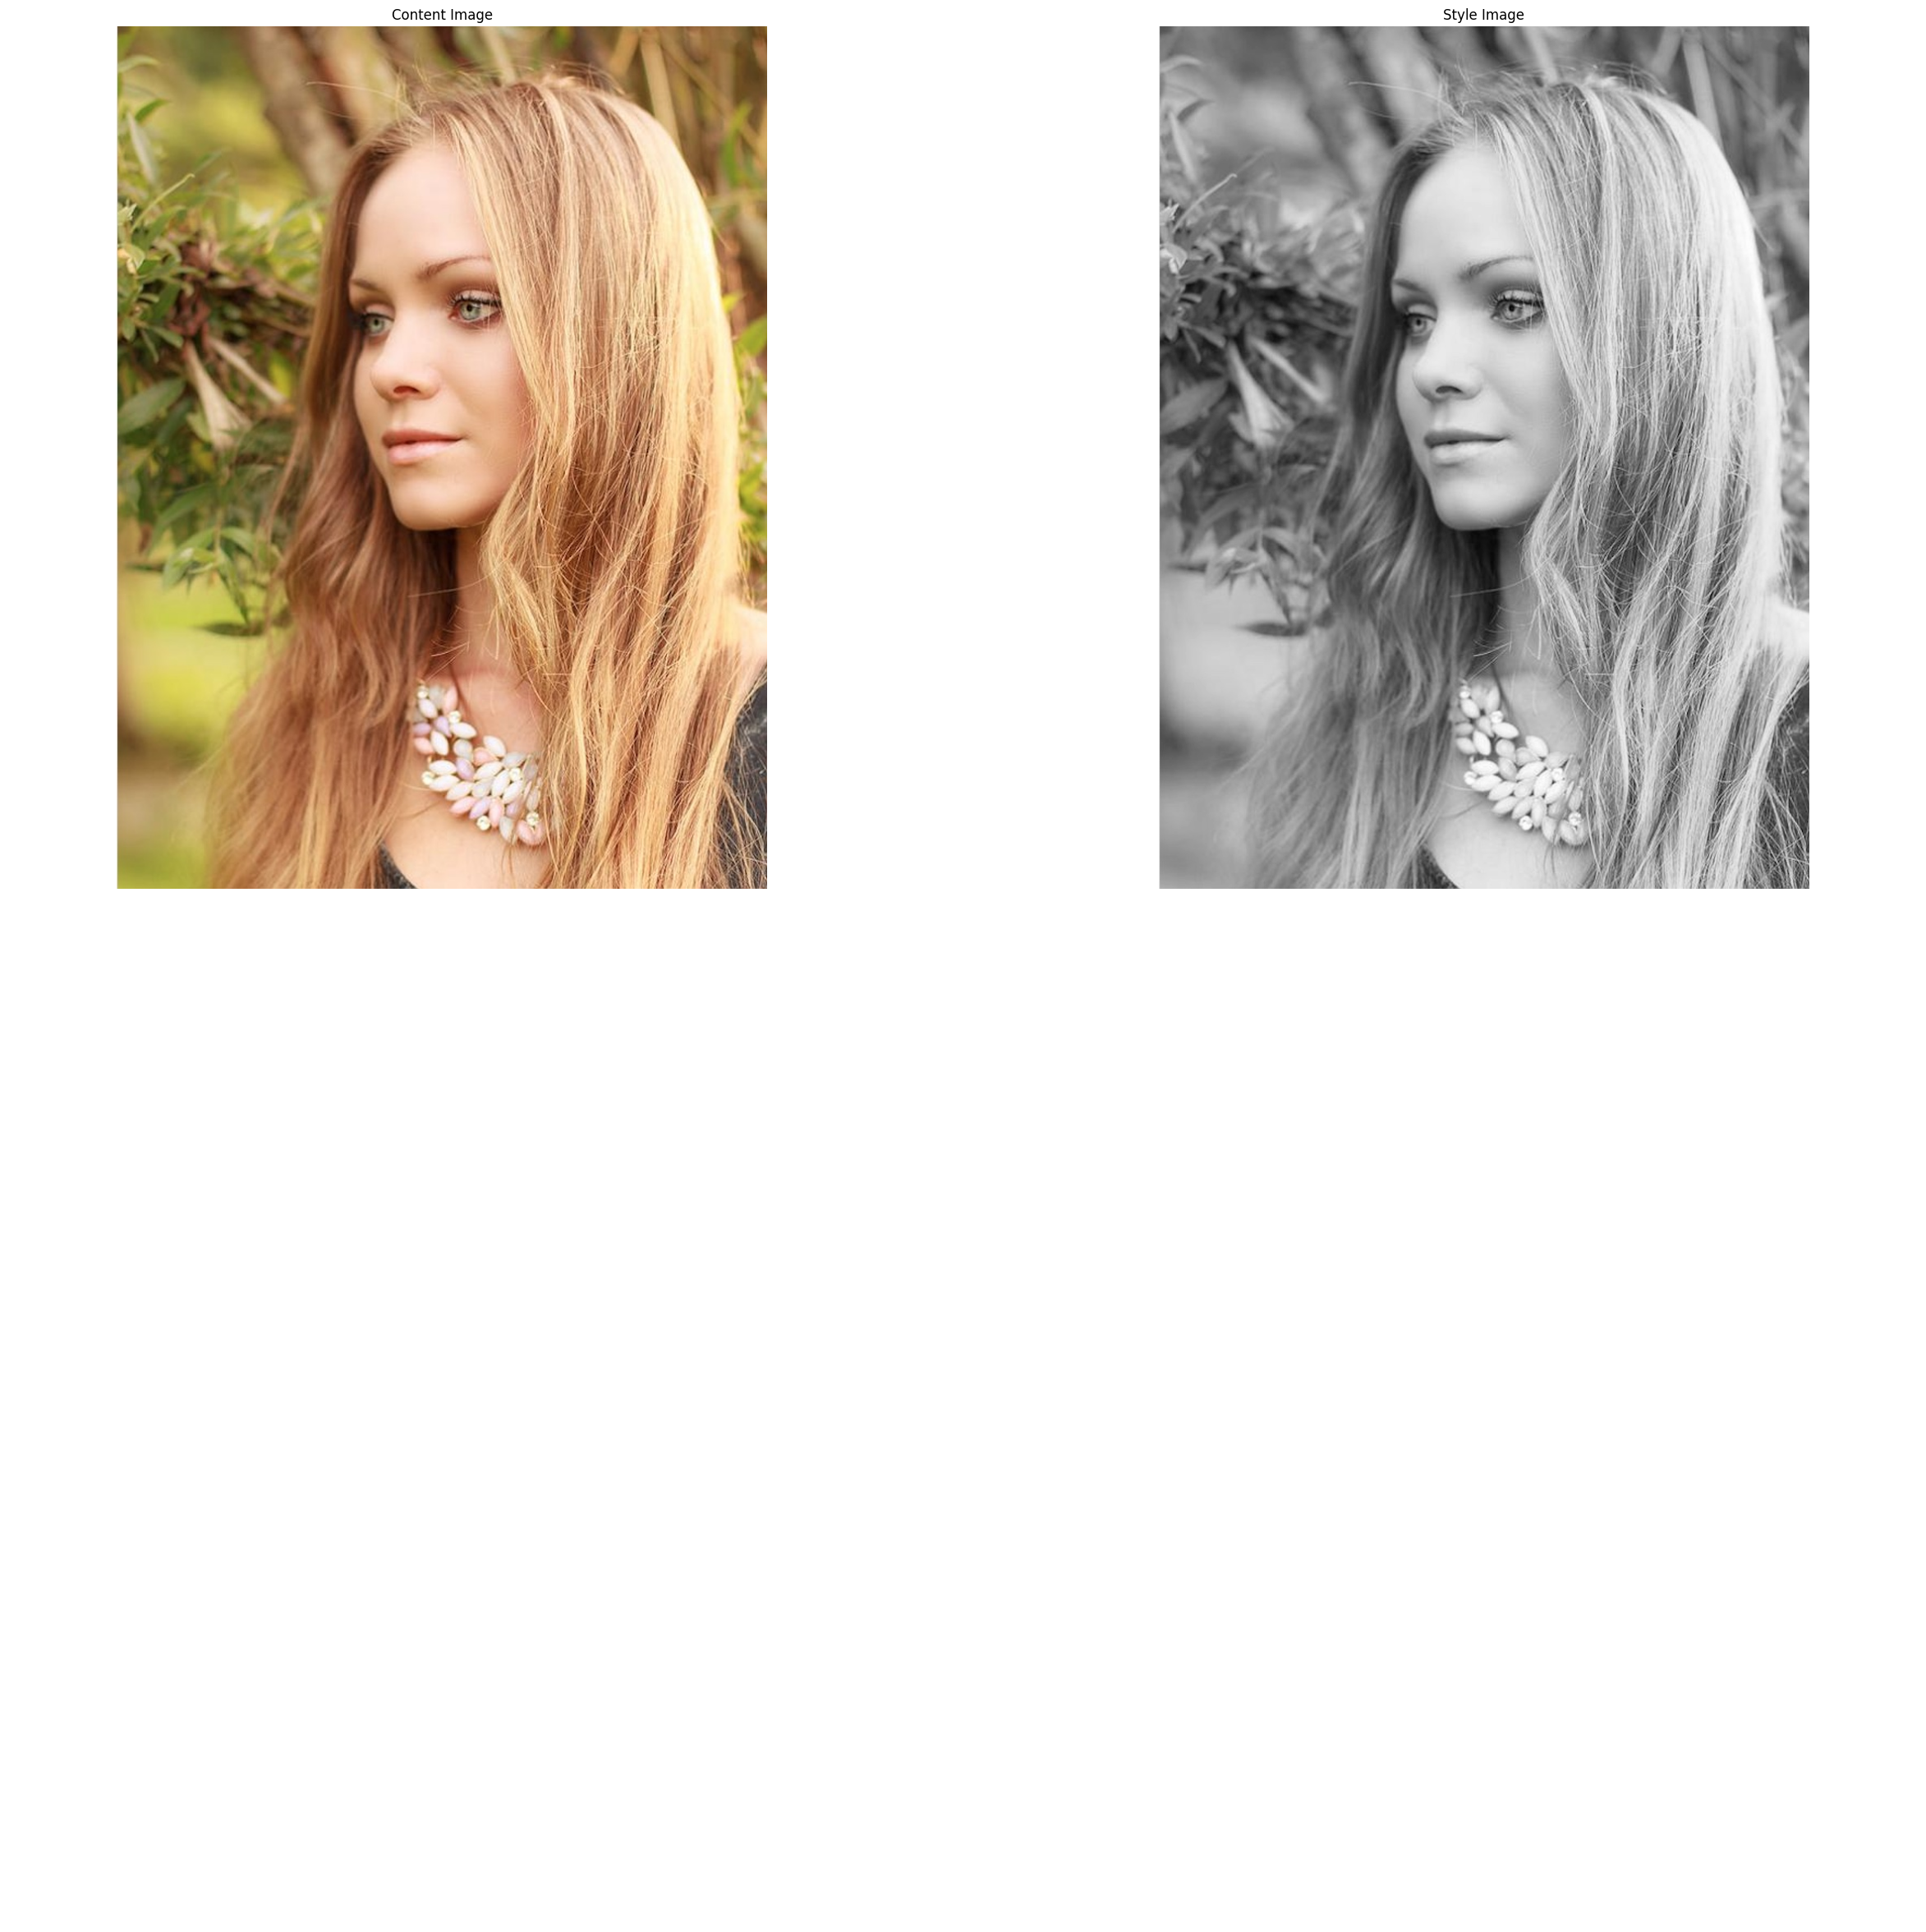

In [60]:
# temp
import matplotlib.pyplot as plt
import cv2

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
[ax.axis("off") for ax in np.ravel(axes)]

content_images = [cv2.cvtColor(cv2.imread('/content/content.jpeg'), cv2.COLOR_BGR2RGB)]
style_images = [cv2.cvtColor(cv2.imread('/content/content.jpeg'), cv2.COLOR_BGR2GRAY)]
for (axis, content_image, style_image) in zip(axes, content_images, style_images):
    (ax_content, ax_style) = axis
    ax_content.imshow(content_image)
    ax_content.set_title("Content Image")
    ax_style.imshow(style_image, cmap='gray', vmin=0, vmax=255)
    ax_style.set_title("Style Image")